In [1]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices
using KrylovKit, IterTools, FFTW
using Dierckx

Random.seed!(123);

In [2]:
# important functions
include("localization3d.jl")


SL (generic function with 1 method)

In [3]:
#=
""" 
    respline(x, y, N)

Use a 2D parametric B-spline to interpolate the closed curve to N points

# Arguments
- `x`: vector of x-coordinates
- `y`: vector of y-coordinates
- `N`: number of desired output points

# Outputs
- a matrix of size 2 x N in [y, x] order containing the splined coordinates

"""
function respline(x, y, N)
    ps = ParametricSpline(vcat(y', x'); s=0.0)
    return evaluate(ps,  LinRange(0, 1, N))
end

""" Spline all curves to have the same number of points """
equalNclosedcurve(thpha, N) = map(thph -> (length(thph) == N) ? thph : hcat(thph[1,1]*ones(N), respline(thph[:,3], thph[:,2], N)'), thpha)
=#

# Generate a random 3D surface

For 3D interpolation, some simplifying assumptions have been made:
- the 3D surface has been supplied as a set of contours in z-direction
- these contours are in sorted order (easy to generalize this)
- each contour has the same number of points (if not, you have to spline the boundary and interpolate, which is not hard), and the same orientation

We will just stack a bunch of blobs.

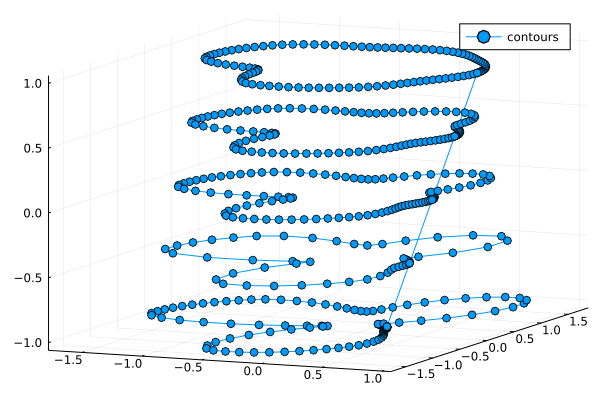

In [21]:
Nz = 5
x, y = blob(Nz,5)
N = 100

z = collect(-2:2)/2

Nx = length(x[1])
hcat(x[1], y[1])

# z, y, x is the order
thpha = map(i -> hcat(ones(length(y[i]))*z[i], y[i], x[i]), 1:Nz)

ind = vcat(collect(1:2:100), 100)

# Shorten the second closed curve
thpha[2] = hcat(thpha[2][ind, 1], thpha[2][ind, 2], thpha[2][ind, 3])

# println(size(thph))
thph = vcat(thpha...)
# This is necessary to close the curve
thph = vcat(thph, thph[1,:]')

p = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", marker = :o)

In [22]:
thpha_new = equalNclosedcurve(thpha, N);

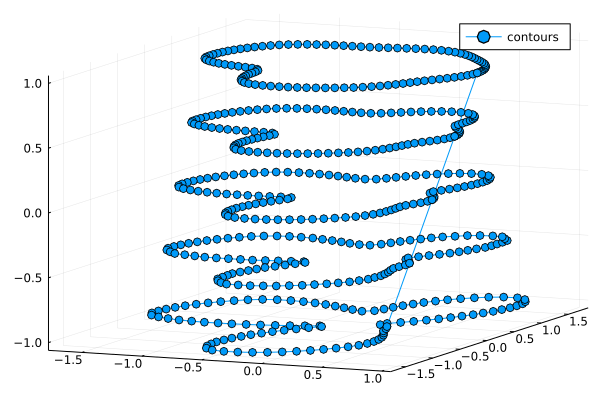

In [23]:
thph_new = vcat(thpha_new...)
p = plot(thph_new[:,3], thph_new[:,2], thph_new[:,1], label = "contours", marker = :o)

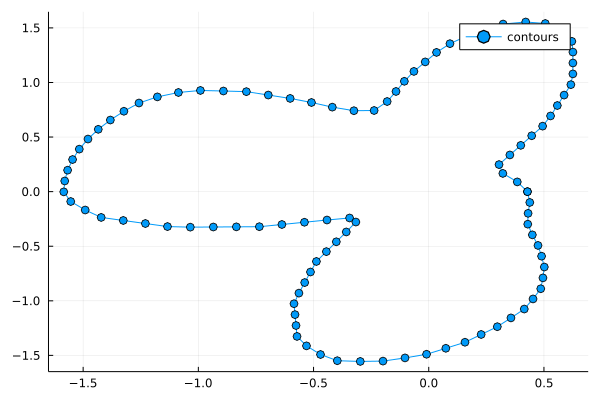

In [24]:
p = plot(thpha_new[2][:,3], thpha_new[2][:,2], label = "contours", marker = :o)

# Fill with quadrature nodes

## Get the quadrature nodes and scale to the range in z

In [25]:
Nqx = Nqy = 16
Nqz = 10

# set parameters for the integration

M  = 3
Kp = [4.0]
szs = int = (Nqx, Nqy, Nqz)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256

256

In [26]:
# compute the nodes - first scale in z
colf, th, wqz = scale_quad_nodez(Nqz, z)

([1, 1, 1, 2, 2, 3, 3, 4, 4, 4], [-0.9739065285171717, -0.8650633666889845, -0.6794095682990244, -0.4333953941292472, -0.1488743389816312, 0.1488743389816312, 0.4333953941292472, 0.6794095682990244, 0.8650633666889845, 0.9739065285171717], [0.06667134430868821, 0.14945134915058048, 0.21908636251598207, 0.2692667193099964, 0.2955242247147528, 0.2955242247147528, 0.2692667193099964, 0.21908636251598207, 0.14945134915058048, 0.06667134430868821])

In [ ]:
"""

    fill2d_new(colf, thpha, th, Nqx, Nqy, N)
    
Fill each 2D level with nodes in x and y

# Arguments
- `colf`: Zero crossing indices where the thph z-coordinate and quadrature node intersect
- `thpha`: The array of arrays of closed curves where the columns are in order (z, y, x)
- `th`: z-level at which crossings are required
- `Nqx`: Number of quadrature nodes in x
- `Nqy`: Number of quadrature nodes in y
- `N::Int64`: Number of points in each closed curve

# Outputs
- `pkg`: The array containing quadrature nodes QX, QY and weights w and Nrun at each level z

"""
function fill2d_new(z, colf, thpha, th, Nqx, Nqy)
    N = size(thpha[1], 1)
    newcurve = map(i -> interpcontour(Float64.(z[colf[i]:(colf[i] + 1)]), th[i], vcat(thpha[colf[i]], thpha[(colf[i] + 1)]), N), 1:length(th))
    pkg = map(nc -> get_quadrature_nodes_2D(nc[:,3], nc[:,2], Nqx, Nqy), newcurve);
    areas =  map(p -> , pkg)
    return newcurve, pkg
end

In [27]:
newcurve, pkg = fill2d(z, colf, thpha_new, th, Nqx, Nqy)

(LinearAlgebra.Adjoint{Float64,Array{Float64,2}}[[-0.9739065285171717 0.0 0.25012617386084285; -0.9739065285171717 0.07111481032921504 0.16441700075258708; … ; -0.9739065285171717 -0.10569803384053128 0.28797528734560773; -0.9739065285171717 -6.126324364033112e-17 0.25012617386084285], [-0.8650633666889845 0.0 0.2910710789437666; -0.8650633666889845 0.07527987004509427 0.21488879336563305; … ; -0.8650633666889845 -0.10415684738541837 0.32256881493447703; -0.8650633666889845 -7.129185303057007e-17 0.2910710789437666], [-0.6794095682990244 0.0 0.36091081003647907; -0.6794095682990244 0.08238421306293679 0.30097853802918506; … ; -0.6794095682990244 -0.10152804540454125 0.38157500042842174; -0.6794095682990244 -8.83976536577705e-17 0.36091081003647907], [-0.4333953941292472 0.0 0.4534570650445432; -0.4333953941292472 0.08876653412747448 0.4121685244775877; … ; -0.4333953941292472 -0.09756713897637118 0.4624961713742452; -0.4333953941292472 -1.110649486515106e-16 0.4534570650445432], [-0.14

In [33]:
sum(pkg[1][3])

2.317741091774779

In [ ]:
""" line 60 of file

    getnodeswts3d_new(szs, pkg, th, wqz)
    
Get the nodes and weights in 3D

# Arguments
- `szs::Tuple{Int64}`: number of quadrature nodes in each dimension
- `pkg`: The array containing quadrature nodes in x, y at each level z
- `th`: z-level at which crossings are required 
- `wqz`: Quadrature weights in the z-direction

# Outputs
- `no`: The quadrature nodes in Tuple format
- `sqwt`: squared weight associated with each node
- `ev`: The even grid of size szs

"""
function getnodeswts3d_new(szs, pkg, th, wqz)
    QX = mapreduce(p -> p[1][:], vcat, pkg)
    QY = mapreduce(p -> p[2][:], vcat, pkg)
    QZ = mapreduce(i -> ones(size(pkg[i][2][:]))*th[i], vcat, 1:length(pkg)); 

    wts = mapreduce(i -> ones(size(pkg[i][2][:]))*wqz[i], vcat, 1:length(pkg));

    no    = map(i->(QX[i], QY[i], QZ[i]), 1:prod(size(QX)))
    sqwt = sqrt.(wts);
    ev = vec(collect(product([range(minimum(QX), maximum(QX), length = szs[1]), range(minimum(QY), maximum(QY), length = szs[2]), range(minimum(QZ), maximum(QZ), length = szs[3]) ]...)))

    return no, sqwt, ev
end

In [28]:
# collate nodes weights
no, sqwt, ev = getnodeswts3d(szs, pkg, th, wqz)

([(-0.43670190469248715, -1.647755755424475, -0.9739065285171717), (-0.43139682366751764, -1.647755755424475, -0.9739065285171717), (-0.422053938107957, -1.647755755424475, -0.9739065285171717), (-0.4090087584687553, -1.647755755424475, -0.9739065285171717), (-0.3927325016842771, -1.647755755424475, -0.9739065285171717), (-0.3738133679199416, -1.647755755424475, -0.9739065285171717), (-0.35293512088801815, -1.647755755424475, -0.9739065285171717), (-0.3308523444677574, -1.647755755424475, -0.9739065285171717), (-0.3083631616936625, -1.647755755424475, -0.9739065285171717), (-0.28628038527340177, -1.647755755424475, -0.9739065285171717)  …  (0.11224384797283567, 0.9848403811885565, 0.9739065285171717), (0.13480213836851912, 0.9848403811885565, 0.9739065285171717), (0.15777558636820882, 0.9848403811885565, 0.9739065285171717), (0.18033387676389223, 0.9848403811885565, 0.9739065285171717), (0.20166170033714664, 0.9848403811885565, 0.9739065285171717), (0.22098822456437608, 0.9848403811885

In [ ]:
#=
    s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
            sqwt = sqwt, int = nothing, ev = ev);
=#

In [29]:
# or you can do it all in one shot, without intermediates:
maxrank = 256
s, sl = slepian3(szs, z, thpha; 
                M = 3, Kp = [4.0], prec = 1e-8, exact = false, lvl = 6, 
                    maxrank = 256, int = nothing)

(Complex{Float64}[67.18672671963483 + 0.0im, 63.64085309081549 + 0.0im, 54.34585888528053 + 0.0im, 52.47721662806165 + 0.0im], Array{Complex{Float64},3}[[-0.0055477730113408655 + 0.0im -0.002633321208806443 + 0.0im … -0.007672401826356604 + 0.0im -0.007776170387084596 + 0.0im; -0.003481904191392606 + 0.0im 0.00042333749357669067 + 0.0im … -0.007559763515340527 + 0.0im -0.008596914916018779 + 0.0im; … ; 0.007236467635933328 + 0.0im 0.007614245810154696 + 0.0im … -0.00934471187988366 + 0.0im -0.003818956891415347 + 0.0im; 0.005733345119648913 + 0.0im 0.006972068955038838 + 0.0im … -8.026827578443652e-5 + 0.0im 0.002399329408277252 + 0.0im]

[-0.004327594932728654 + 0.0im -0.0006807683897673098 + 0.0im … -0.008628225516196087 + 0.0im -0.009184897160518613 + 0.0im; -0.0014011731630547745 + 0.0im 0.0029991025845609713 + 0.0im … -0.006902846449662883 + 0.0im -0.008642965515127802 + 0.0im; … ; 0.00915857507012854 + 0.0im 0.007864924628459759 + 0.0im … -0.022296500957284346 + 0.0im -0.01139082

# Sanity plot 1 - scaled quadrature points in z

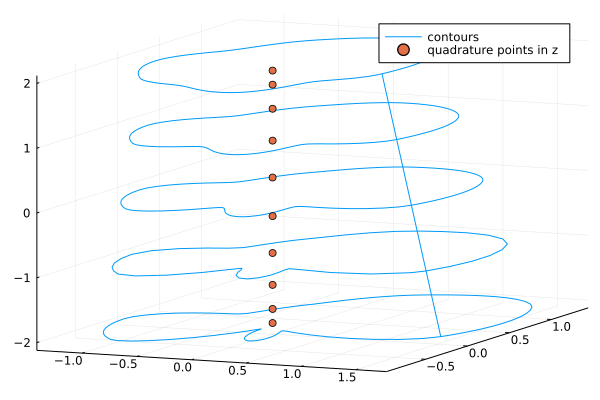

In [13]:
p1 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p1, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")

# Sanity plot II: Show the quadrature closed curves at each z level

Get the (x,y) values at each quadrature level z. 

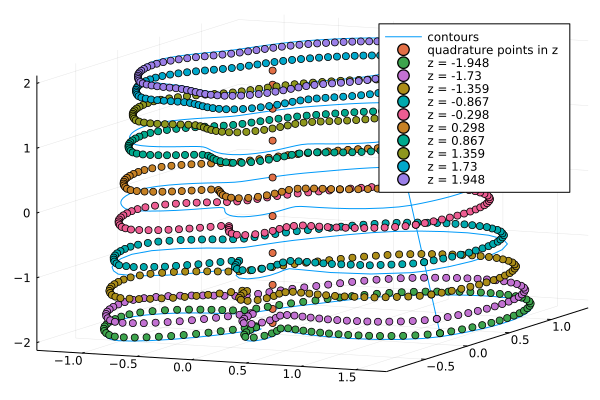

In [14]:
p2 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p2, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")
for i = 1:length(th)
    scatter!(p2, newcurve[i][:,3],newcurve[i][:,2],newcurve[i][:,1], label = "z = $(round(1000*th[i])/1000)")
end
p2

# Sanity plots III - IV: plot in 2D the quadrature nodes we are getting at each level.

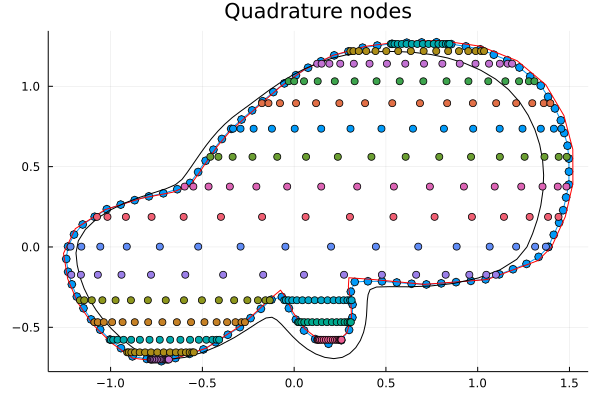

In [15]:
i = 4
N=100
q = plot(newcurve[i][:,3], newcurve[i][:,2], marker=:o, c = 1, label = "z = $(round(1000*th[i])/1000)")

plot!(q, thpha[colf[i]][:, 3], thpha[colf[i]][:,2], label = "z = $(thph[colf[i]][1,1])", c = :red)
plot!(q, thpha[colf[i]+1][:, 3], thpha[colf[i]+1][:,2], label = "z = $(thph[colf[i] + 1][1,1])", c = :black)


scatter!(q, pkg[i][1], pkg[i][2], legend = false, title = "Quadrature nodes")


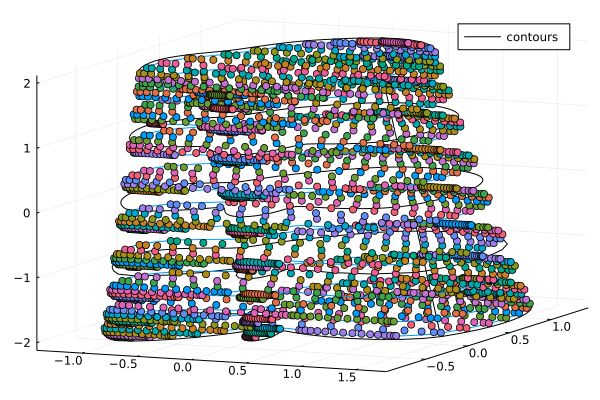

In [16]:
p3 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
for i = 1:10
    plot!(p3, newcurve[i][:,3], newcurve[i][:,2], ones(size(newcurve[i][:,2]))*th[i], c = 1, label = "")
    scatter!(p3, pkg[i][1], pkg[i][2], ones(Nqx,Nqy+1)*th[i] , label = "")
end
p3

# Sanity plot V - Show the sequences

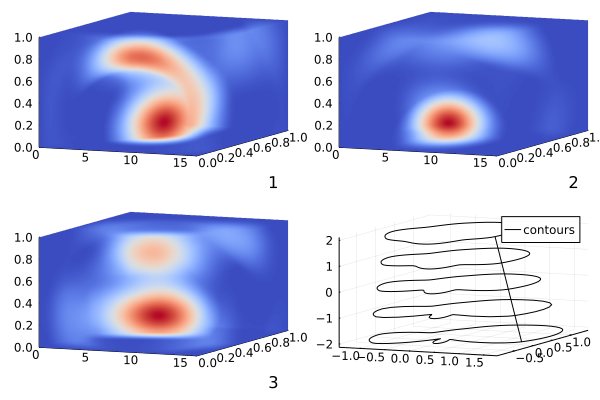

In [17]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ssl = SL(sl)
ran = 1:3
for i = ran
    p1[i] = heatmap( Float64.(sl[i]),
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i) # this transpose is important
    #plot!(p1[i], x[1], y[1], legend = false, c = :black)

    # ssl = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(log10.(ssl[i]), ylabel = i)
end

psimple = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
plot(p1[1:3]..., psimple)

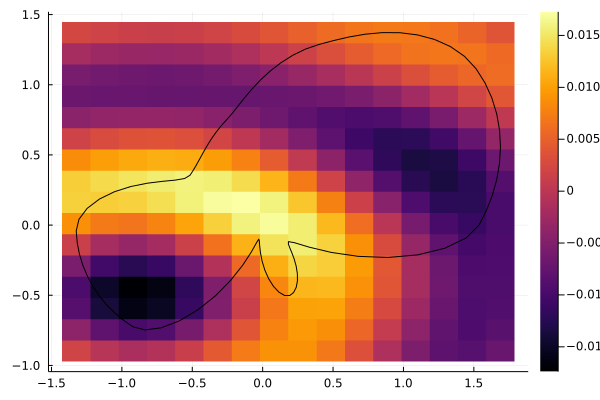

In [18]:
heatmap(range(minimum(thph[:,3]), maximum(thph[:,3]), length = szs[1]), 
         range(minimum(thph[:,2]), maximum(thph[:,2]), length = szs[2]), Float64.(sl[1][:,:,1]))
plot!(thpha[1][:,3], thpha[1][:,2], c = :black, legend = false)

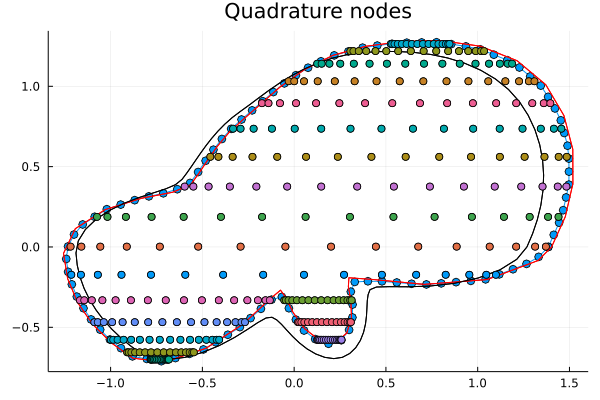

In [19]:
heatmap(range(minimum(thph[:,3]), maximum(thph[:,3]), length = szs[1]), 
         range(minimum(thph[:,2]), maximum(thph[:,2]), length = szs[2]), Float64.(sl[1][:,:,1]))

plot!(newcurve[i][:,3], newcurve[i][:,2], marker=:o, c = 1, label = "z = $(round(1000*th[i])/1000)")

plot!(q, thpha[colf[i]][:, 3], thpha[colf[i]][:,2], label = "z = $(thph[colf[i]][1,1])", c = :red)
plot!(q, thpha[colf[i]+1][:, 3], thpha[colf[i]+1][:,2], label = "z = $(thph[colf[i] + 1][1,1])", c = :black)


scatter!(q, pkg[i][1], pkg[i][2], legend = false, title = "Quadrature nodes")

# Sanity plot VI: Show the FFTs

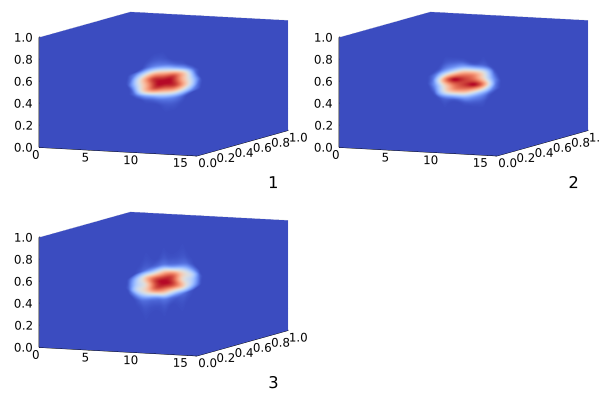

In [20]:
plot(p2[ran]...)